In [1]:
import os
import glob
import pandas as pd

import tqdm

import lightning
from lightning.pytorch.callbacks import ModelCheckpoint

from src.change_detection import ChangeDetectionTask
from src.datasets.levircd import LEVIRCDDataModule

/home/dark/code/python/change-detection/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import glob
import pandas as pd
from sklearn.metrics import roc_curve, auc, confusion_matrix
import numpy as np

from tqdm import tqdm
import lightning as lightning
import matplotlib.pyplot as plt
import torch

In [3]:
predictions = []
targets = []

In [12]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch

root="test"
train_root="train"
model="unetsiamdiff"
backbone="resnet50"
epochs=200
batch_size=8
workers=8
lr=0.01
accelerator="gpu"
device=0
num_seeds=10

def show_random_detection_result(ckpt, inp):
    """Shows detection result for a random image from the dataset."""
    root="test"
    datamodule = LEVIRCDDataModule(
            root=root,
            batch_size=batch_size,
            patch_size=256,
            num_workers=workers,
        )


    module = ChangeDetectionTask.load_from_checkpoint(ckpt, map_location="cpu")
    # Get a random image and target from the dataloader
    datamodule.setup("test")
    dataset = datamodule.test_dataloader().dataset

    data = dataset[inp]
    image1, image2, target = data["image1"], data["image2"], data["mask"]

    image_pair = torch.cat([image1, image2], dim=0)
    image_pair = image_pair.unsqueeze(0)
    prediction = module(image_pair)

    # Process prediction (e.g., thresholding, converting to binary mask)
    # This might vary depending on your model's output
    prediction = prediction.squeeze().detach().cpu().numpy()  # Assuming a single-channel output
    prediction = (prediction > 0.5).astype(np.uint8)  # Threshold at 0.5

    # Convert image and prediction to PIL Images
    image1 = image1.squeeze().permute(1, 2, 0).cpu().numpy()  # Convert to HWC format
    image1 = (image1 * 255).astype(np.uint8)  # Scale to 0-255
    image1 = Image.fromarray(image1)
    image2 = image2.squeeze().permute(1, 2, 0).cpu().numpy()  # Convert to HWC format
    image2 = (image2 * 255).astype(np.uint8)  # Scale to 0-255
    image2 = Image.fromarray(image2)
    target = target.squeeze().cpu().numpy()  # Convert to numpy array
    target = (target * 255).astype(np.uint8)  # Scale to 0-255
    target = Image.fromarray(target)

    if prediction.ndim != 2:
        prediction = prediction.squeeze()

    prediction = prediction[1]  # Select the first channel (adjust index if needed)

    prediction = prediction.reshape(image1.size[::-1]) # Reshape to (height, width) to match image1
    prediction = prediction.astype(np.uint8) # Ensure data type is uint8

    prediction_image = Image.fromarray(prediction * 255)  # Assuming binary mask

    color_map = np.zeros((256, 3), dtype=np.uint8)
    color_map[255] = [255, 255, 0]  # Yellow for background (0)
    color_map[0] = [128, 0, 128]  # Purple for changed areas (255)

    prediction_np = np.array(prediction_image)
    prediction_image = Image.fromarray(color_map[prediction_np])
    prediction_image = prediction_image.convert("RGB")

    # Display images side-by-side
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    axes[0].imshow(image1)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    axes[1].imshow(image2)
    axes[1].set_title("Changed Image")
    axes[1].axis("off")
    axes[2].imshow(target, cmap="gray")
    axes[2].set_title("Target")
    axes[3].imshow(prediction_image, cmap="gray")
    axes[3].set_title("Detection Result")
    plt.show()

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import torch

def generate_roc_and_confusion_matrix(model_path, datamodule):
    """
    Generates and displays the ROC curve and confusion matrix for a change detection model.

    Args:
        model_path (str): Path to the saved model checkpoint.
        datamodule (lightning.LightningDataModule): Data module for the dataset.
    """
    module = ChangeDetectionTask.load_from_checkpoint(model_path)

    # Get predictions and ground truth labels
    predictions = []
    targets = []
    for batch in datamodule.test_dataloader():
        image1, image2, target = batch["image1"], batch["image2"], batch["mask"]
        image_pair = torch.cat([image1, image2], dim=1)  # Concatenate images
        prediction = module(image_pair)
        predictions.extend(prediction.flatten().detach().cpu().numpy())
        targets.extend(target.flatten().detach().cpu().numpy())

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    roc_auc = auc(fpr, tpr)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(targets, (predictions > 0.5).astype(int))  # Threshold at 0.5

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No Change', 'Change'])
    disp.plot()
    plt.show()

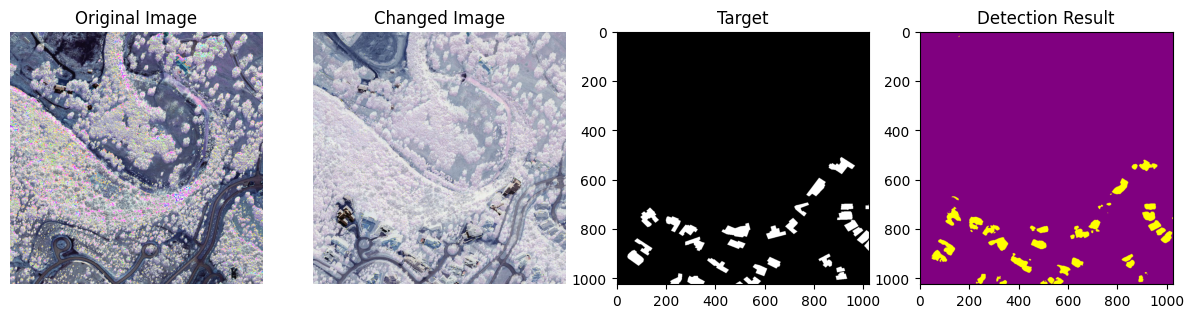

In [13]:
checkpoint_root = "checkpoints"

# checkpoints = glob.glob(f"{checkpoint_root}/*.ckpt")


# for ckpt in checkpoints:
#     show_random_detection_result(ckpt)

show_random_detection_result("checkpoints/last.ckpt",43)

In [ ]:
model_path = "checkpoints/last.ckpt"
datamodule = LEVIRCDDataModule(
    root="test",
    batch_size=batch_size,
    patch_size=256,
    num_workers=workers,
)
datamodule.setup("test")
# Generate ROC curve and confusion matrix
generate_roc_and_confusion_matrix(model_path, datamodule)